In [5]:
import pandas as pd
import re
import string
import joblib
import multiprocessing
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import VotingClassifier

In [6]:
# Download NLTK resources
download('stopwords')
download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Santosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Santosh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Load fake and real news datasets
fake = pd.read_csv('Fake (1).csv')
true = pd.read_csv('True (1).csv')

In [8]:
# Add labels
fake['class'] = 0  # FAKE news
true['class'] = 1  # REAL news

In [9]:
# Combine datasets & shuffle
data = pd.concat([fake, true], axis=0).sample(frac=1, random_state=42)
data = data.drop(["title", "subject", "date"], axis=1).reset_index(drop=True)
fake_count, real_count = data['class'].value_counts()
print(f"Fake News: {fake_count}, Real News: {real_count}")


Fake News: 23481, Real News: 21417


In [10]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [11]:
# Optimized text cleaning function with lemmatization
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r"\[.*?\]", "", text)  # Remove text inside brackets
    text = re.sub(r"\W", " ", text)  # Remove non-word characters
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>+", "", text)  # Remove HTML tags
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)  # Remove punctuation
    text = re.sub(r"\n", " ", text)  # Remove newlines
    text = re.sub(r"\w*\d\w*", "", text)  # Remove words with numbers
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatize words
    return text  # Ensure it return the cleaned text

In [13]:
# Apply text cleaning
data['text'] = data['text'].apply(clean_text)

In [14]:
# Splitting the dataset
x = data["text"]
y = data["class"]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

In [15]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, max_features=5000)
xv_train = vectorizer.fit_transform(xtrain)
xv_test = vectorizer.transform(xtest)

In [16]:
# Hyperparameter tuning for Random Forest
rf_param_dist = {
    'n_estimators': [50, 75],
    'max_depth': [5],
    'min_samples_split': [5],
    'warm_start': [True]
}

# Set n_iter to match the number of combinations in  grid
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_param_dist,
    n_iter=2,  # Set n_iter to 2 to match the grid size
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random_search.fit(xv_train, ytrain)
rf_best = rf_random_search.best_estimator_

print("Best parameters found: ", rf_random_search.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found:  {'warm_start': True, 'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 5}


In [17]:
# Hyperparameter tuning for Logistic Regression
lr_param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 500]}
lr_grid_search = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, n_jobs=-1, verbose=1)
lr_grid_search.fit(xv_train, ytrain)
lr_best = lr_grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [18]:

# Train Models
lr_best.fit(xv_train, ytrain)
rf_best.fit(xv_train, ytrain)
svm_model = LinearSVC(C=1, max_iter=2000)
svm_model.fit(xv_train, ytrain)
nb_model = MultinomialNB()
nb_model.fit(xv_train, ytrain)

c:\Users\Santosh\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\Santosh\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


MultinomialNB()

In [19]:
# Set up the Voting Classifier with soft voting
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_best), ('rf', rf_best), ('svm', svm_model), ('nb', nb_model)
], voting='soft')

# Fit the Voting Classifier
voting_clf.fit(xv_train, ytrain)

c:\Users\Santosh\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, max_iter=500,
                                                 solver='saga')),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_split=5,
                                                     n_estimators=50,
                                                     warm_start=True)),
                             ('svm', LinearSVC(C=1, max_iter=2000)),
                             ('nb', MultinomialNB())],
                 voting='soft')

In [20]:

# Initialize the Voting Classifier with hard voting
voting_clf = VotingClassifier(estimators=[
    ('log_reg', lr_best),
    ('rf', rf_best),
    ('svc', svm_model),
    ('nb', nb_model)
], voting='hard')  # Using 'hard' voting for majority class prediction.

# Fit the Voting Classifier on the training data
voting_clf.fit(xv_train, ytrain)

# List of models to evaluate
models = {
    "Logistic Regression": lr_best,
    "Random Forest": rf_best,
    "SVM": svm_model,
    "Naive Bayes": nb_model,
    "Voting Classifier": voting_clf
}

accuracy_scores, f1_scores = {}, {}

# Evaluate each model
for model_name, model in models.items():
    try:
        y_pred = model.predict(xv_test)
        accuracy_scores[model_name] = accuracy_score(ytest, y_pred)
        f1_scores[model_name] = f1_score(ytest, y_pred)
        print(f"{model_name} Accuracy: {accuracy_scores[model_name]:.4f}")
        print(f"{model_name} F1-Score: {f1_scores[model_name]:.4f}")
        print(classification_report(ytest, y_pred))
    except Exception as e:
        print(f"Error in {model_name}: {e}")


c:\Users\Santosh\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9921
Logistic Regression F1-Score: 0.9917
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5863
           1       0.99      0.99      0.99      5362

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

Random Forest Accuracy: 0.9650
Random Forest F1-Score: 0.9635
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5863
           1       0.96      0.97      0.96      5362

    accuracy                           0.96     11225
   macro avg       0.96      0.97      0.96     11225
weighted avg       0.97      0.96      0.96     11225

SVM Accuracy: 0.9925
SVM F1-Score: 0.9922
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5863
           1       0.99      0.99      0.99      5362

    

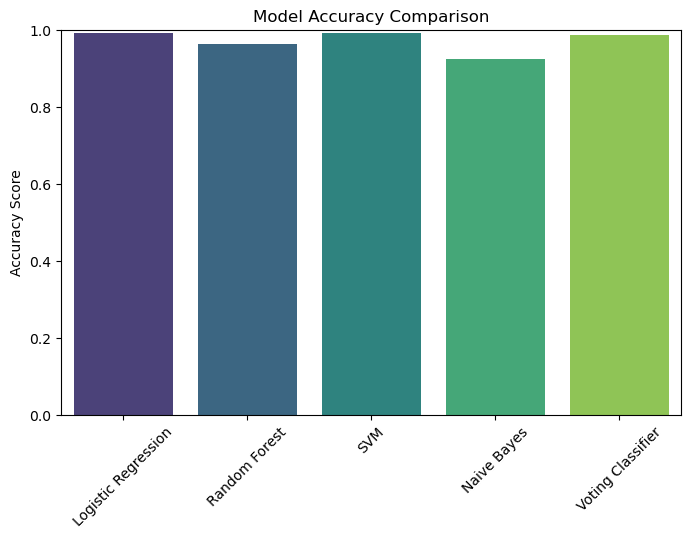

In [21]:

# Ensure models exist before plotting
if len(models) == 0:
    print("No models available for evaluation.")
else: 
    # Accuracy Barplot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='viridis')
    plt.ylim(0, 1)
    plt.ylabel("Accuracy Score")
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=45)
    plt.show()

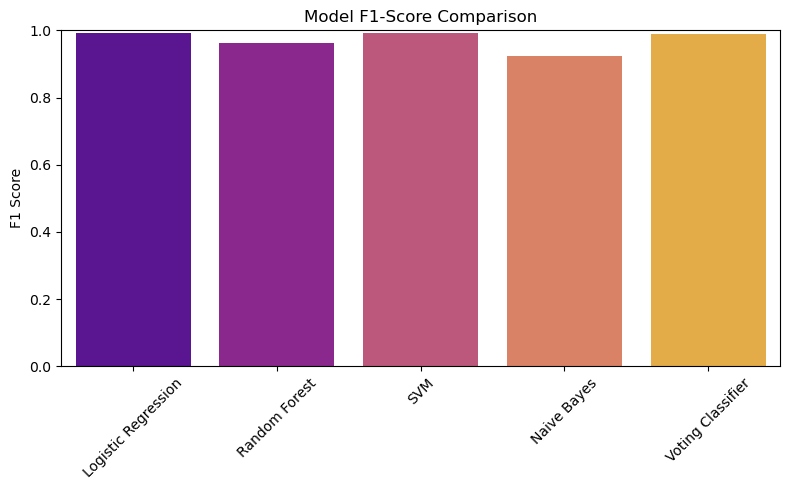

In [22]:

# F1 Score Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='plasma')
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Model F1-Score Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


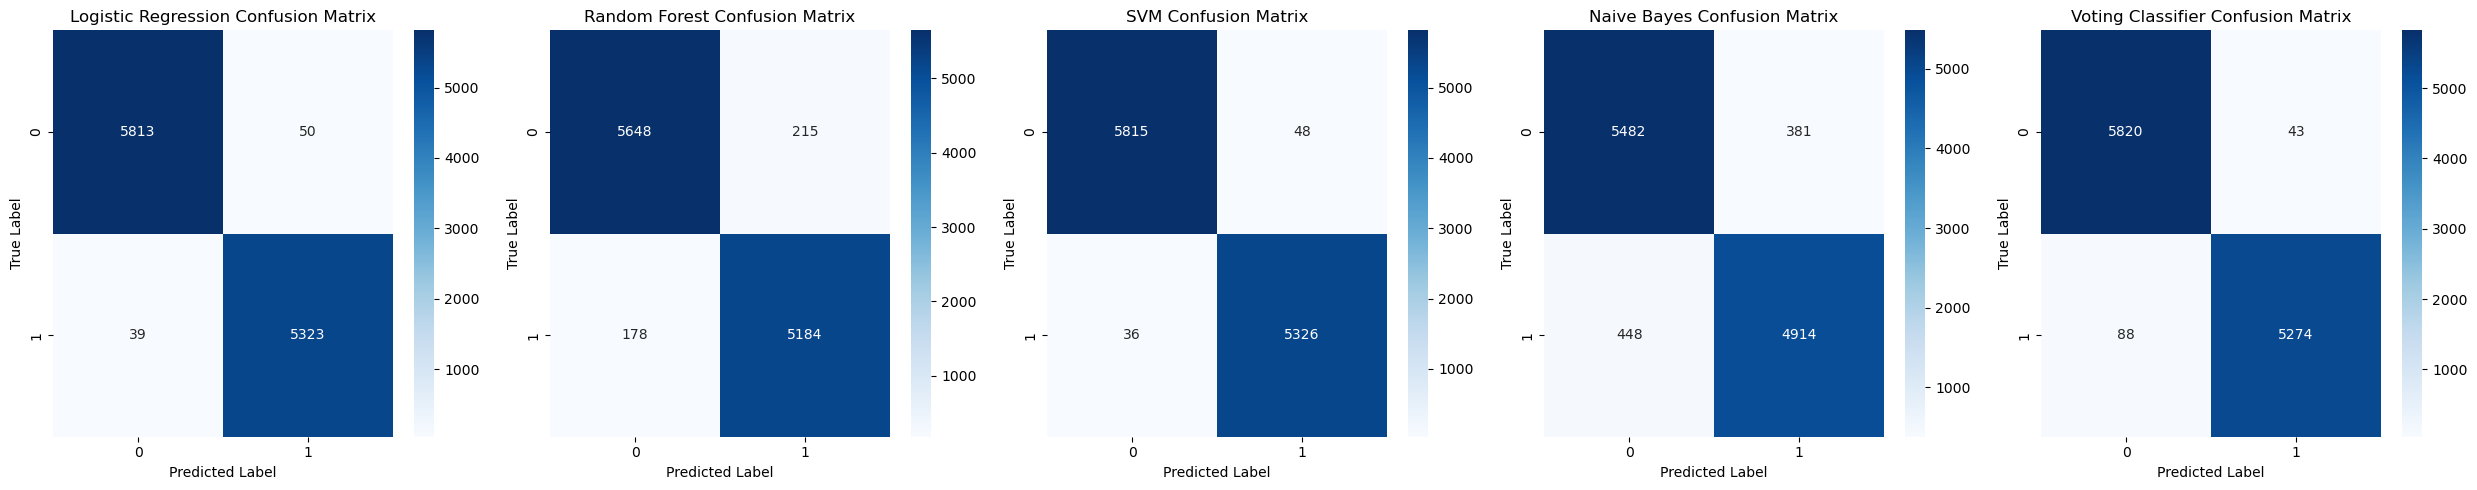

In [23]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 5)) if len(models) > 1 else plt.subplots(1, 1, figsize=(5, 5))
axes = [axes] if len(models) == 1 else axes  # Ensure axes are iterable

for i, (model_name, model) in enumerate(models.items()):
    try:
        sns.heatmap(confusion_matrix(ytest, model.predict(xv_test)), annot=True, fmt="d", cmap="Blues", ax=axes[i]).set(
            title=f"{model_name} Confusion Matrix", xlabel="Predicted Label", ylabel="True Label")
    except Exception as e:
        print(f"Error with model {model_name}: {e}")

plt.tight_layout()
plt.show()

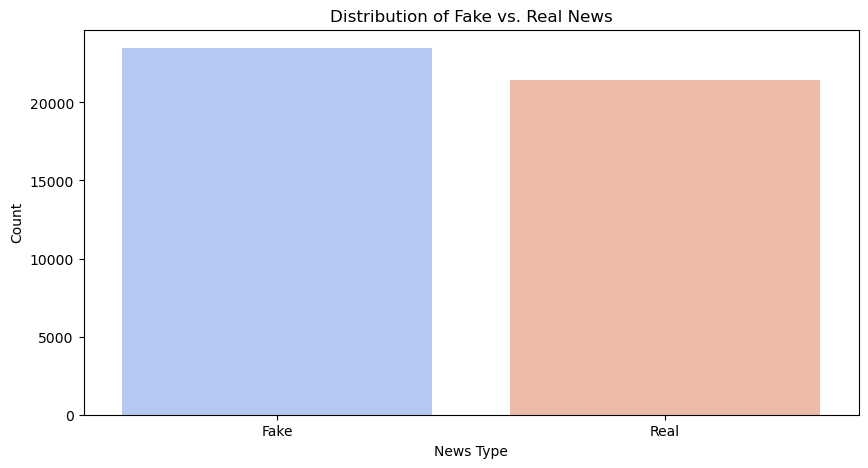

In [24]:
# Bar plot of Fake vs. Real News distribution
plt.figure(figsize=(10,5))
sns.countplot(x=data['class'], palette='coolwarm', order=[0,1])
plt.xticks([0, 1], ['Fake', 'Real'])
plt.xlabel("News Type")
plt.ylabel("Count")
plt.title("Distribution of Fake vs. Real News")
plt.show()

In [25]:
# Save Models
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

joblib.dump(vectorizer, "saved_models/vectorizer.jb")
for model_name, model in models.items():
    joblib.dump(model, f"saved_models/{model_name.lower().replace(' ', '_')}.jb")